# Classify Song Genres from Audio Data

## Introduction

Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.

For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. 

## Importing libraries

In [42]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import joblib

## Understanding Data

To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as danceability and acousticness on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON.

Let's start by creating two pandas DataFrames out of these files that we can merge so we have features and labels for the classification later on.

In [2]:
# Read in track metadata with genre labels
tracks = pd.read_csv('fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('echonest-metrics.json', precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['genre_top', 'track_id']], on='track_id')

# Inspect the resultant dataframe
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [3]:
# Check for missing values
print(echo_tracks.isnull().sum())

track_id            0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
genre_top           0
dtype: int64


In [4]:
# Display the number of rows and columns in the dataset
print("Number of rows and columns:", echo_tracks.shape)

print("\n")

# Display summary statistics for numerical variables
print(echo_tracks.describe())

Number of rows and columns: (4802, 10)


            track_id  acousticness  danceability       energy  \
count    4802.000000  4.802000e+03   4802.000000  4802.000000   
mean    30164.871720  4.870600e-01      0.436556     0.625126   
std     28592.013796  3.681396e-01      0.183502     0.244051   
min         2.000000  9.491000e-07      0.051307     0.000279   
25%      7494.250000  8.351236e-02      0.296047     0.450757   
50%     20723.500000  5.156888e-01      0.419447     0.648374   
75%     44240.750000  8.555765e-01      0.565339     0.837016   
max    124722.000000  9.957965e-01      0.961871     0.999768   

       instrumentalness     liveness  speechiness        tempo      valence  
count       4802.000000  4802.000000  4802.000000  4802.000000  4802.000000  
mean           0.604096     0.187997     0.104877   126.687944     0.453413  
std            0.376487     0.150562     0.145934    34.002473     0.266632  
min            0.000000     0.025297     0.023234    29.09300

**Initial Observations**

1.The dataset consists of 4802 songs, each described by 10 features. 


2.There are no missing values, and the features exhibit diverse characteristics.


3.On average, the songs have moderate acousticness (mean = 0.487), moderate danceability (mean = 0.437), high energy (mean = 0.625), and a notable degree of instrumentalness (mean = 0.604). 


4.Songs tend to have low liveness (mean = 0.188) and speechiness (mean = 0.105). 


5.The tempo is moderately paced (mean = 126.688), and the songs express a moderate level of valence (mean = 0.453). 


6.The dataset showcases variability, with instrumentalness and energy having the highest standard deviations (0.376 and 0.244, respectively), indicating a wide range of values across songs.

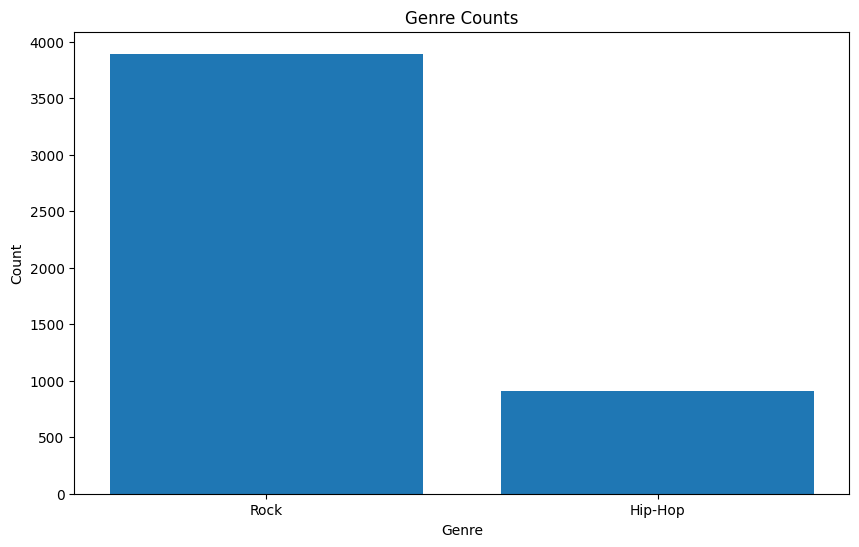

In [5]:
# Visualize the distribution of the target variable (genre_top)
genre_counts = echo_tracks['genre_top'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']

plt.figure(figsize=(10, 6))
plt.bar(genre_counts['Genre'], genre_counts['Count'])
plt.title('Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


We have 3892 song samples classified as 'Rock' genre and only 910 samples classified as 'Hip-Hop' genre. This indicates an imbalance in the class distribution, with a significantly larger number of samples belonging to the 'Rock' genre compared to the 'Hip-Hop' genre.

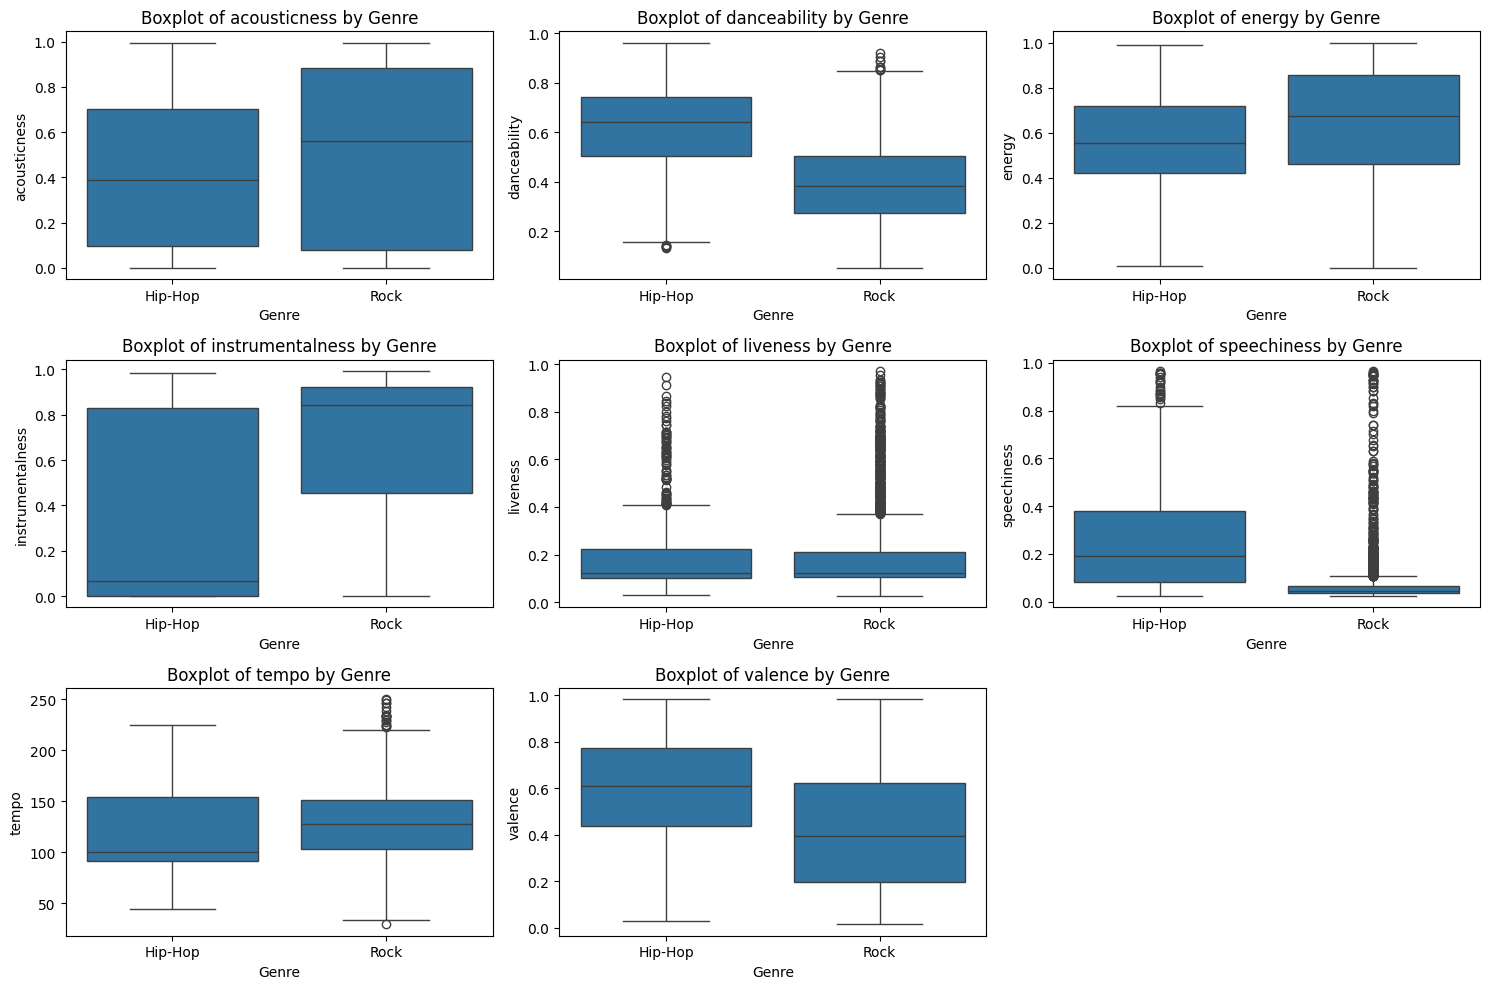

In [6]:
# Boxplots for each numerical feature with respect to genre_top
plt.figure(figsize=(15, 10))
for i, column in enumerate(['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='genre_top', y=column, data=echo_tracks)
    plt.title(f'Boxplot of {column} by Genre')
    plt.xlabel('Genre')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [7]:
# Creating a correlation matrix
corr_metrics = echo_tracks[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']].corr()
corr_metrics.style.background_gradient()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
acousticness,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


We typically want to avoid using variables that have strong correlations with each other --- hence avoiding feature redundancy --- for a few reasons:

    1.To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).
    2.When our datasets are very large, using fewer features can drastically speed up our computation time.


But we didn't find any particularly strong correlations between our features

## Preprocessing

In [8]:
# Drop unnecessary columns
echo_tracks = echo_tracks.drop(['track_id'], axis=1)

Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.

To account for this, we perform resampling, which involves undersampling the majority class ('Rock') to reduce its dominance. 

In [9]:
# Handling class imbalances
# Subset a balanced proportion of data points
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# subset only the rock songs, and take a sample the same size as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# concatenate the dataframes hop_only and rock_only
rock_hop_bal = pd.concat([rock_only, hop_only])

## Splitting data

In [10]:
# Create features
features = rock_hop_bal.drop(["genre_top"], axis=1).values

# Create labels
labels = rock_hop_bal["genre_top"].values

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels,
                                                                            random_state=10)

## Normalizing data

Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called principal component analysis (PCA).

It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.

However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our train and test features. There are a few methods to do this, but a common way is through standardization, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).

In [11]:
# Scale train_features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

## Feature Selection - PCA

Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use scree-plots and cumulative explained ratio plots to find the number of components to use in further analyses.

Text(0.5, 0, 'Principal Component #')

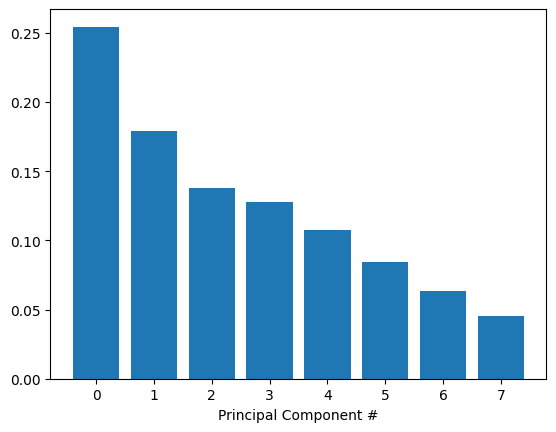

In [12]:
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method.

But all is not lost! Instead, we can also look at the cumulative explained variance plot to determine how many features are required to explain, say, about 85% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.

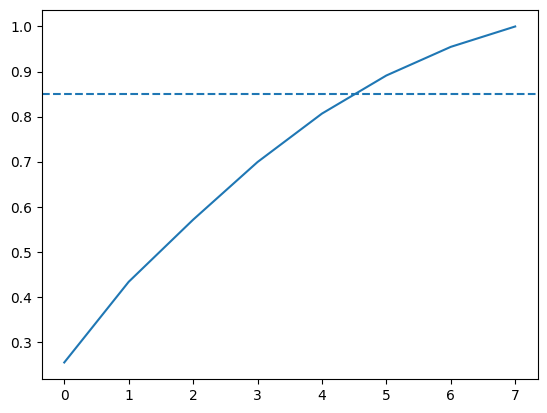

In [13]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

We saw from the plot that 6 features (remember indexing starts at 0) can explain 85% of the variance!

Therefore, we can use 6 components to perform PCA and reduce the dimensionality of our train and test features.



In [14]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components=6, random_state=10)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test_features)

## Model Building

The following models are build and evaluated:

    1. Logistic Regression
    
    2. Support Vector Machine
    
    3. Decision Trees
    
    4. Random Forest

In [26]:
# Fit and evaluate logistic regression classifier
lr = LogisticRegression(random_state=42)
lr.fit(train_pca,train_labels)
# perform cv with 5 folds
cv_scores = cross_val_score(lr, train_pca, train_labels, cv=5, scoring='accuracy')
mean_cv_score = cv_scores.mean()
# train accuracy
lr_score_train = lr.score(train_pca,train_labels)
# test accuracy
lr_score_test = lr.score(test_pca,test_labels)
print('Mean Cross-Validated Score: {:.2f}%'.format(mean_cv_score*100))
print("Logistic Regression Classifier Train Accuracy: {:.2f}%".format(lr_score_train*100))
print("Logistic Regression Classifier Test Accuracy: {:.2f}%".format(lr_score_test*100))

Mean Cross-Validated Score: 82.20%
Logistic Regression Classifier Train Accuracy: 82.64%
Logistic Regression Classifier Test Accuracy: 82.42%


In [29]:
# Fit and evaluate support vector machine classifier
svm = SVC(random_state=42)
svm.fit(train_pca,train_labels)
# perform cv
cv_scores = cross_val_score(svm, train_pca, train_labels, cv=5, scoring='accuracy')
mean_cv_score = cv_scores.mean()
# train accuracy
svm_score_train = svm.score(train_pca,train_labels)
# test accuracy
svm_score_test = svm.score(test_pca,test_labels)
print('Mean Cross-Validated Score: {:.2f}%'.format(mean_cv_score*100))
print("Support Vector Machine Classifier Train Accuracy: {:.2f}%".format(svm_score_train*100))
print("Support Vector Machine Classifier Test Accuracy: {:.2f}%".format(svm_score_test*100))

Mean Cross-Validated Score: 85.20%
Support Vector Machine Classifier Train Accuracy: 87.69%
Support Vector Machine Classifier Test Accuracy: 85.93%


In [30]:
# Fit and evaluate decision tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_pca,train_labels)
# perform cv
cv_scores = cross_val_score(dt, train_pca, train_labels, cv=5, scoring='accuracy')
mean_cv_score = cv_scores.mean()
# train accuracy
dt_score_train = dt.score(train_pca,train_labels)
# test accuracy
dt_score_test = dt.score(test_pca,test_labels)
print('Mean Cross-Validated Score: {:.2f}%'.format(mean_cv_score*100))
print("Decision Tree Classifier Train Accuracy: {:.2f}%".format(dt_score_train*100))
print("Decision Tree Classifier Test Accuracy: {:.2f}%".format(dt_score_test*100))

Mean Cross-Validated Score: 80.00%
Decision Tree Classifier Train Accuracy: 100.00%
Decision Tree Classifier Test Accuracy: 78.02%


In [31]:
# Fit and evaluate random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(train_pca,train_labels)
# perform cv
cv_scores = cross_val_score(rf, train_pca, train_labels, cv=5, scoring='accuracy')
mean_cv_score = cv_scores.mean()
# train accuracy
rf_score_train = rf.score(train_pca,train_labels)
# test accuracy
rf_score_test = rf.score(test_pca,test_labels)
print('Mean Cross-Validated Score: {:.2f}%'.format(mean_cv_score*100))
print("Random Forest Classifier Train Accuracy: {:.2f}%".format(rf_score_train*100))
print("Random Forest Classifier Test Accuracy: {:.2f}%".format(rf_score_test*100))

Mean Cross-Validated Score: 84.76%
Random Forest Classifier Train Accuracy: 100.00%
Random Forest Classifier Test Accuracy: 85.49%


**Insights**

- Logistic Regression and SVM show relatively consistent performance across cross-validation and test sets.

- Decision Tree and Random Forest have a noticeable difference between train and test accuracies, suggesting a potential overfitting issue.

- Considering hyperparameter tuning of Decision Tree and Random Forest to control overfitting.

## Hyperparameter Tuning and Evaluation

In [35]:
# Define the hyperparameter grid
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'min_samples_leaf': [1, 2, 4, 10, 20]
}

# Perform GridSearchCV
dt_grid_search = GridSearchCV(dt, dt_param_grid, cv=5, scoring='accuracy')
dt_grid_search.fit(train_pca, train_labels)

# Get the best model,parameters and the corresponding mean cross-validated score
best_model_dt = dt_grid_search.best_estimator_
best_params_dt = dt_grid_search.best_params_
best_score_dt = dt_grid_search.best_score_

# Print the results
print("Best Parameters for Decision Tree:", best_params_dt)
print("Best Mean Cross-Validated Score for Decision Tree:", best_score_dt)


Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 100}
Best Mean Cross-Validated Score for Decision Tree: 0.8212454212454212


In [38]:
# Evaluate the Decision Tree on the test set
dt_test_pred = best_model_dt.predict(test_pca)
dt_test_accuracy = accuracy_score(test_labels, dt_test_pred)

# Print the results for Decision Tree
print("Decision Tree Test Accuracy:", dt_test_accuracy)
print("Decision Tree Classification Report:")
print(classification_report(test_labels, dt_test_pred))
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(test_labels, dt_test_pred))

Decision Tree Test Accuracy: 0.8197802197802198
Decision Tree Classification Report:
              precision    recall  f1-score   support

     Hip-Hop       0.83      0.80      0.82       230
        Rock       0.81      0.84      0.82       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455

Decision Tree Confusion Matrix:
[[185  45]
 [ 37 188]]


In [40]:
# Define the hyperparameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform GridSearchCV
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(train_pca, train_labels)

# Get the best model,parameters and the corresponding mean cross-validated score
best_model_rf = rf_grid_search.best_estimator_
best_params_rf = rf_grid_search.best_params_
best_score_rf = rf_grid_search.best_score_

# Print the results
print("Best Parameters for Random Forest:", best_params_rf)
print("Best Mean Cross-Validated Score for Random Forest:", best_score_rf)

Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Mean Cross-Validated Score for Random Forest: 0.8490842490842491


In [41]:
# Evaluate the Random Forest on the test set
rf_test_pred = best_model_rf.predict(test_pca)
rf_test_accuracy = accuracy_score(test_labels, rf_test_pred)

# Print the results for Random Forest
print("\nRandom Forest Test Accuracy:", rf_test_accuracy)
print("Random Forest Classification Report:")
print(classification_report(test_labels, rf_test_pred))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(test_labels, rf_test_pred))


Random Forest Test Accuracy: 0.8483516483516483
Random Forest Classification Report:
              precision    recall  f1-score   support

     Hip-Hop       0.87      0.82      0.84       230
        Rock       0.82      0.88      0.85       225

    accuracy                           0.85       455
   macro avg       0.85      0.85      0.85       455
weighted avg       0.85      0.85      0.85       455

Random Forest Confusion Matrix:
[[188  42]
 [ 27 198]]


Both models show good performance on the test set, with accuracy around 82% for Decision Tree and 85% for Random Forest.Random Forest outperforms the Decision Tree in terms of accuracy and other metrics.But Random Forest Classifier's test accuracy was already 85.49% before tuning, and the accuracy after tuning is 84.84%, it suggests that the tuning process did not improve the model's performance on the test set. In some cases, hyperparameter tuning may not always lead to better results.

In [43]:
# Save the best model to disk
joblib.dump(best_model_rf, 'song_classifier.joblib')

['song_classifier.joblib']